In [1]:
import pandas as pd
import numpy as np
import dateutil.easter as easter
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from pycaret.regression import *

In [2]:
train_df = pd.read_csv("train.csv",index_col=0)
test_df = pd.read_csv("test.csv",index_col=0)
# The dates are read as strings and must be converted
for df in [train_df, test_df]:
    df['date'] = pd.to_datetime(df.date)
    df.set_index('date', inplace=True, drop=False)
train_df

,date,country,store,product,num_sold
date,,,,,
2015-01-01,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
2015-01-01,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2015-01-01,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
2015-01-01,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
2015-01-01,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...
2018-12-31,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
2018-12-31,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
2018-12-31,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004


In [3]:
print(train_df.groupby(['country', 'store', 'product']).date.count())

print("First day:", train_df.date.min(), "   Last day:", train_df.date.max())
print("Number of days in four years:", 365 * 4 + 1) # four years including one leap year
print(18 * 1461, train_df.shape, train_df.date.isna().sum())

country  store       product       
Finland  KaggleMart  Kaggle Hat        1461
                     Kaggle Mug        1461
                     Kaggle Sticker    1461
         KaggleRama  Kaggle Hat        1461
                     Kaggle Mug        1461
                     Kaggle Sticker    1461
Norway   KaggleMart  Kaggle Hat        1461
                     Kaggle Mug        1461
                     Kaggle Sticker    1461
         KaggleRama  Kaggle Hat        1461
                     Kaggle Mug        1461
                     Kaggle Sticker    1461
Sweden   KaggleMart  Kaggle Hat        1461
                     Kaggle Mug        1461
                     Kaggle Sticker    1461
         KaggleRama  Kaggle Hat        1461
                     Kaggle Mug        1461
                     Kaggle Sticker    1461
Name: date, dtype: int64
First day: 2015-01-01 00:00:00    Last day: 2018-12-31 00:00:00
Number of days in four years: 1461
26298 (26298, 5) 0


In [4]:
train_df.groupby(['country', 'store', 'product']).num_sold.agg(['min', 'max', 'mean'])

min   max         mean
country store      product                               
Finland KaggleMart Kaggle Hat      210  1113   362.479808
                   Kaggle Mug      126   774   204.200548
                   Kaggle Sticker   70   326   103.044490
        KaggleRama Kaggle Hat      354  1895   628.926762
                   Kaggle Mug      220  1398   356.110883
                   Kaggle Sticker  128   559   180.232033
Norway  KaggleMart Kaggle Hat      335  1809   594.645448
                   Kaggle Mug      201  1113   334.370294
                   Kaggle Sticker  114   518   169.577687
        KaggleRama Kaggle Hat      596  2884  1036.357974
                   Kaggle Mug      366  1935   584.297741
                   Kaggle Sticker  214   874   295.607803
Sweden  KaggleMart Kaggle Hat      248  1207   419.214237
                   Kaggle Mug      149   730   235.885010
                   Kaggle Sticker   86   356   119.613279
        KaggleRama Kaggle Hat      428  2169   731.452430
                   Kaggle Mug      253  1438   411.273101
                   Kaggle Sticker  148   637   208.314853

In [5]:
test_df.date.min(), test_df.date.max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [6]:
kk = train_df.groupby(['country', 'store', 'product']).num_sold.mean().unstack(level='store')
kk['KaggleRama:KaggleMart'] = kk.KaggleRama / kk.KaggleMart
kk

store                   KaggleMart   KaggleRama  KaggleRama:KaggleMart
country product                                                       
Finland Kaggle Hat      362.479808   628.926762               1.735067
        Kaggle Mug      204.200548   356.110883               1.743927
        Kaggle Sticker  103.044490   180.232033               1.749070
Norway  Kaggle Hat      594.645448  1036.357974               1.742817
        Kaggle Mug      334.370294   584.297741               1.747457
        Kaggle Sticker  169.577687   295.607803               1.743200
Sweden  Kaggle Hat      419.214237   731.452430               1.744818
        Kaggle Mug      235.885010   411.273101               1.743532
        Kaggle Sticker  119.613279   208.314853               1.741570

In [7]:
# Group by year
kk = train_df.groupby(['country', 'store', 'product', train_df.date.dt.year]).num_sold.mean().unstack(level='product')
kk['Mugs/Sticker'] = kk['Kaggle Mug'] / kk['Kaggle Sticker']
kk['Hats/Sticker'] = kk['Kaggle Hat'] / kk['Kaggle Sticker']
kk

product                   Kaggle Hat  Kaggle Mug  Kaggle Sticker  \
country store      date                                            
Finland KaggleMart 2015   328.947945  185.657534       93.517808   
                   2016   342.773224  192.155738       97.174863   
                   2017   372.758904  210.479452      106.082192   
                   2018   405.493151  228.542466      115.419178   
        KaggleRama 2015   573.260274  322.868493      163.813699   
                   2016   596.931694  335.158470      169.871585   
                   2017   644.789041  367.315068      185.936986   
                   2018   700.813699  399.158904      201.334247   
Norway  KaggleMart 2015   570.076712  320.043836      161.936986   
                   2016   545.489071  306.849727      156.221311   
                   2017   601.043836  337.942466      171.227397   
                   2018   662.106849  372.720548      188.961644   
        KaggleRama 2015   991.465753  556.156164      281.635616   
                   2016   952.767760  538.267760      272.286885   
                   2017  1046.578082  592.904110      299.679452   
                   2018  1154.849315  649.989041      328.893151   
Sweden  KaggleMart 2015   396.342466  222.854795      112.863014   
                   2016   407.322404  227.469945      115.609290   
                   2017   432.728767  244.750685      123.254795   
                   2018   440.495890  248.487671      126.736986   
        KaggleRama 2015   691.939726  388.676712      196.821918   
                   2016   709.106557  399.095628      201.983607   
                   2017   752.857534  423.035616      214.846575   
                   2018   771.967123  434.317808      219.624658   

product                  Mugs/Sticker  Hats/Sticker  
country store      date                              
Finland KaggleMart 2015      1.985264      3.517490  
                   2016      1.977422      3.527386  
                   2017      1.984117      3.513869  
                   2018      1.980108      3.513222  
        KaggleRama 2015      1.970949      3.499465  
                   2016      1.973011      3.514017  
                   2017      1.975481      3.467783  
                   2018      1.982568      3.480847  
Norway  KaggleMart 2015      1.976348      3.520361  
                   2016      1.964199      3.491771  
                   2017      1.973647      3.510208  
                   2018      1.972467      3.503922  
        KaggleRama 2015      1.974737      3.520385  
                   2016      1.976841      3.499132  
                   2017      1.978461      3.492325  
                   2018      1.976292      3.511321  
Sweden  KaggleMart 2015      1.974560      3.511713  
                   2016      1.967575      3.523267  
                   2017      1.985730      3.510847  
                   2018      1.960656      3.475670  
        KaggleRama 2015      1.974763      3.515562  
                   2016      1.975881      3.510713  
                   2017      1.969013      3.504164  
                   2018      1.977546      3.514938

In [8]:
# Group by month
kk = train_df.groupby(['product', train_df.date.dt.month]).num_sold.mean().unstack(level='product')
kk['Mugs/Sticker'] = kk['Kaggle Mug'] / kk['Kaggle Sticker']
kk['Hats/Sticker'] = kk['Kaggle Hat'] / kk['Kaggle Sticker']
kk

product,Kaggle Hat,Kaggle Mug,Kaggle Sticker,Mugs/Sticker,Hats/Sticker
date,,,,,
1,688.612903,419.631720,187.096774,2.242859,3.680517
2,686.278761,372.073746,169.793510,2.191331,4.041843
3,729.115591,353.951613,172.145161,2.056123,4.235470
4,784.891667,352.075000,184.615278,1.907074,4.251499
5,752.611559,329.176075,186.262097,1.767274,4.040605
6,662.947222,301.909722,178.951389,1.687105,3.704622
7,573.794355,290.754032,172.998656,1.680672,3.316756
8,509.762097,303.047043,171.380376,1.768272,2.974448
9,476.206944,326.465278,172.684722,1.890528,2.757667


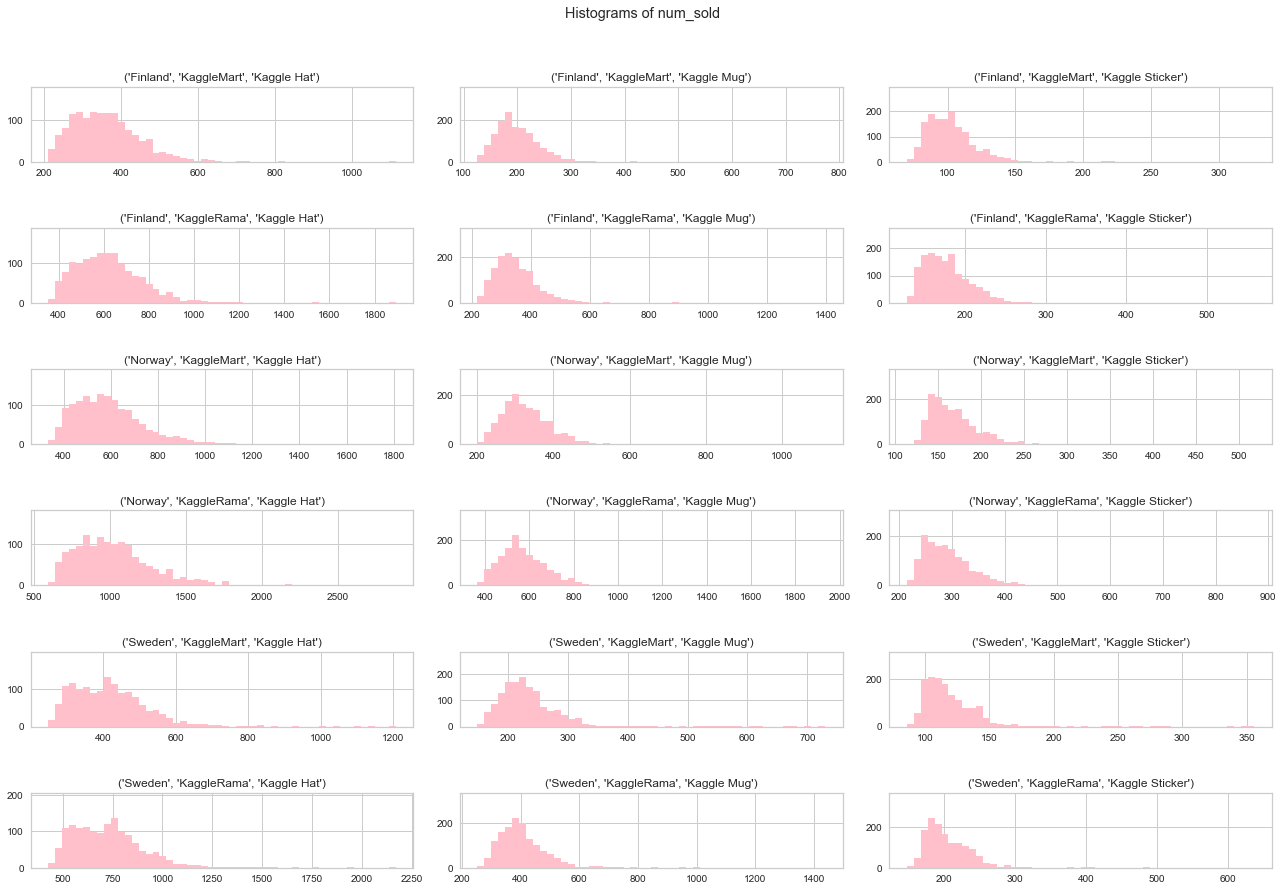

In [11]:

plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    ax.hist(df.num_sold, bins=50, color='pink')
    #ax.set_xscale('log')
    ax.set_title(combi)
plt.suptitle('Histograms of num_sold', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

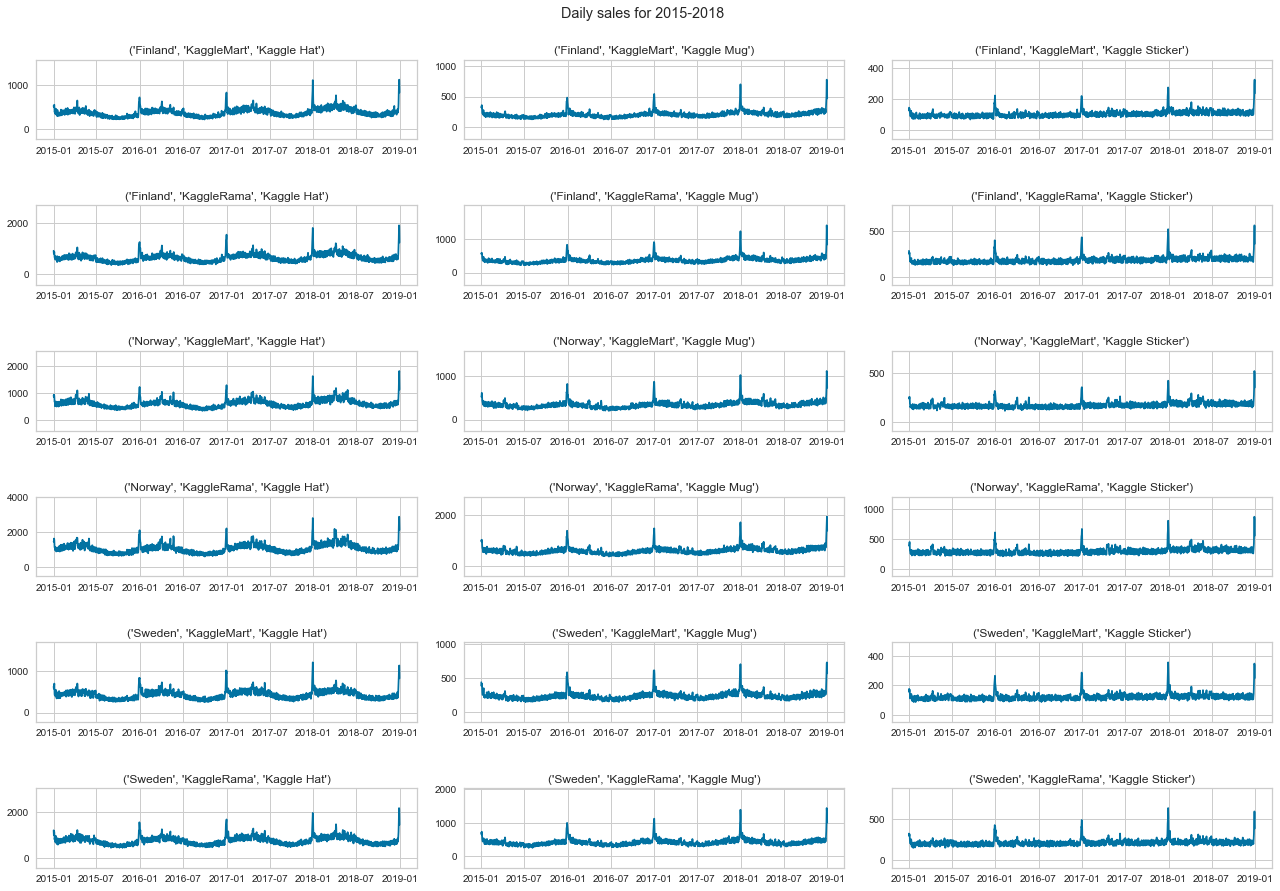

In [9]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    #print(df.num_sold.values.shape, df.num_sold.values)
    ax.plot(df.num_sold)
    ax.set_title(combi)
    #if i == 6: break
plt.tight_layout(h_pad=3.0)
plt.suptitle('Daily sales for 2015-2018', y=1.03)
plt.show()

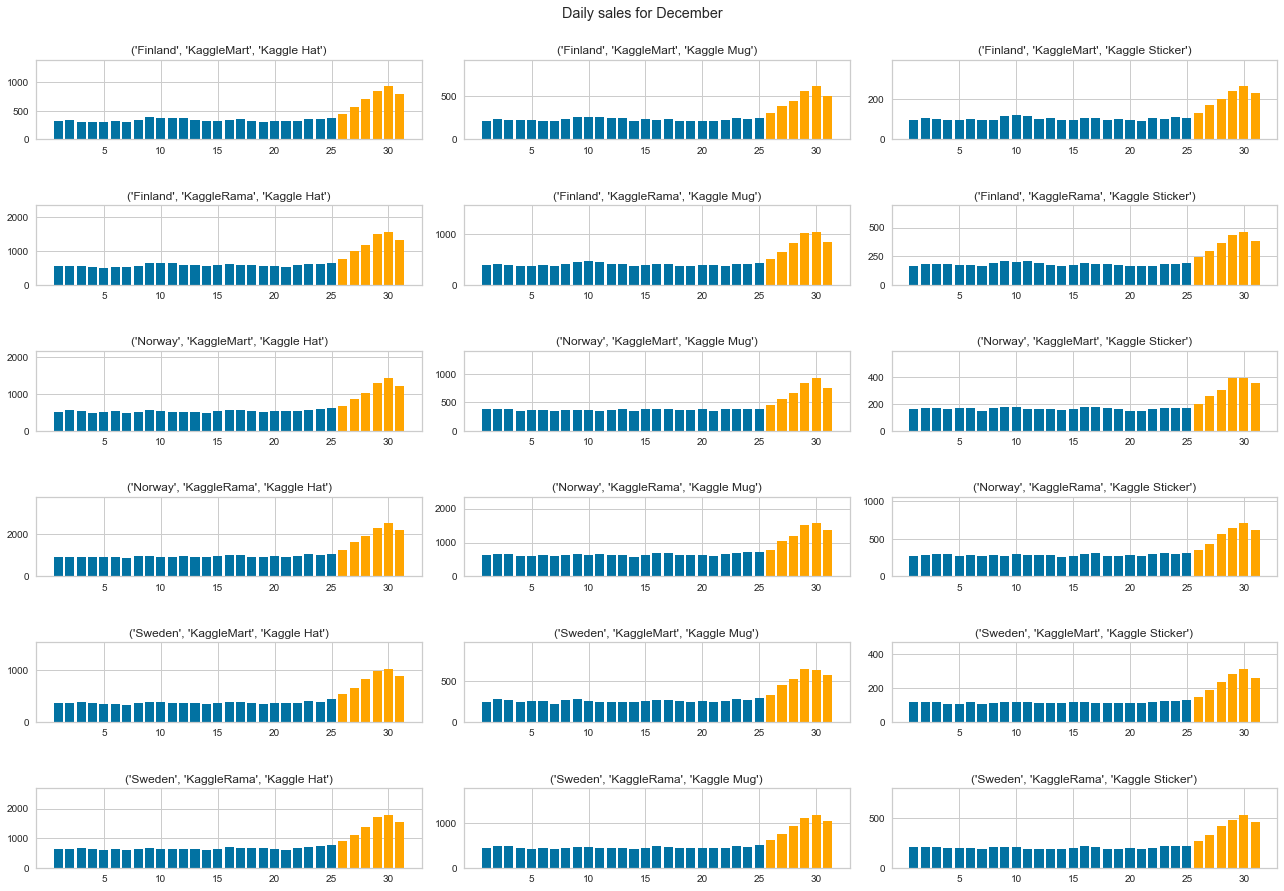

In [10]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    ax.bar(range(1, 32),
           df.num_sold[df.date.dt.month==12].groupby(df.date.dt.day).mean(),
           color=['b'] * 25 + ['orange'] * 6)
    ax.set_title(combi)
    ax.set_xticks(ticks=range(5, 31, 5))
plt.tight_layout(h_pad=3.0)
plt.suptitle('Daily sales for December', y=1.03)
plt.show()

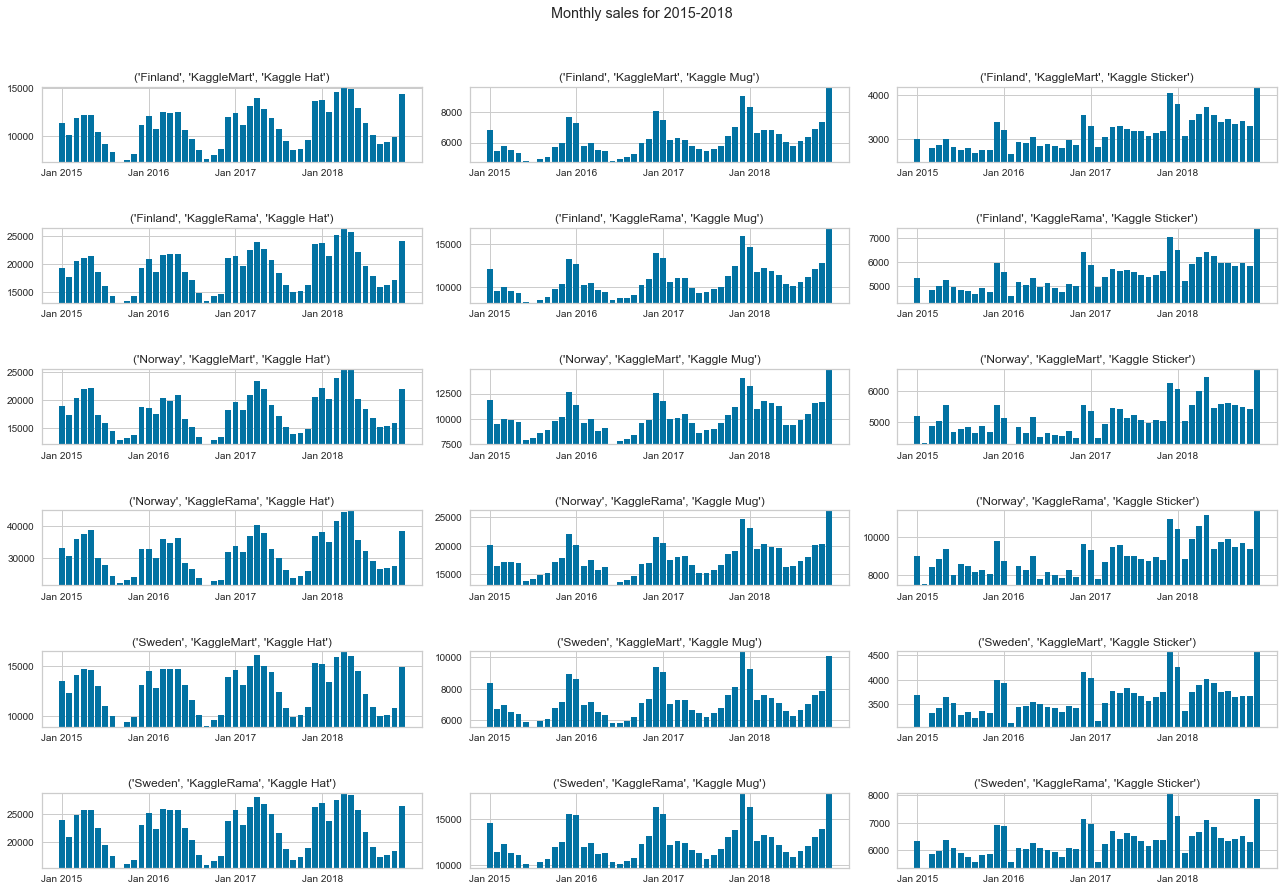

In [11]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    #print(df.resample('MS').num_sold.sum())
    resampled = df.resample('MS').num_sold.sum()
    ax.bar(range(len(resampled)), resampled)
    ax.set_title(combi)
    ax.set_ylim(resampled.min(), resampled.max())
    ax.set_xticks(range(0, 48, 12), [f"Jan {y}" for y in range(2015, 2019)])
plt.suptitle('Monthly sales for 2015-2018', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

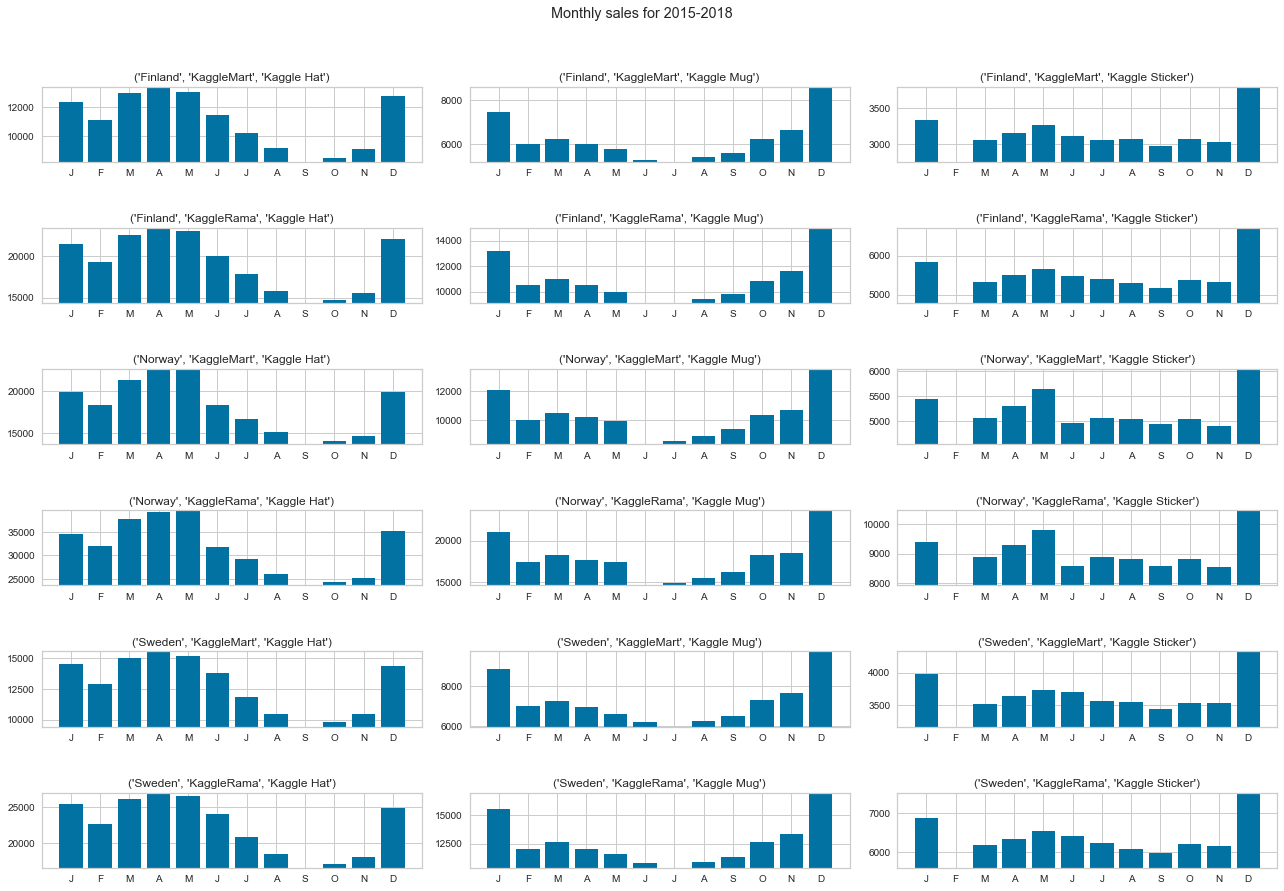

In [12]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    resampled = df.resample('MS').sum()
    resampled = resampled.groupby(resampled.index.month).mean()
    ax.bar(range(1, 13), resampled.num_sold)
    ax.set_xticks(ticks=range(1, 13), labels='JFMAMJJASOND')
    ax.set_title(combi)
    ax.set_ylim(resampled.num_sold.min(), resampled.num_sold.max())
plt.suptitle('Monthly sales for 2015-2018', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

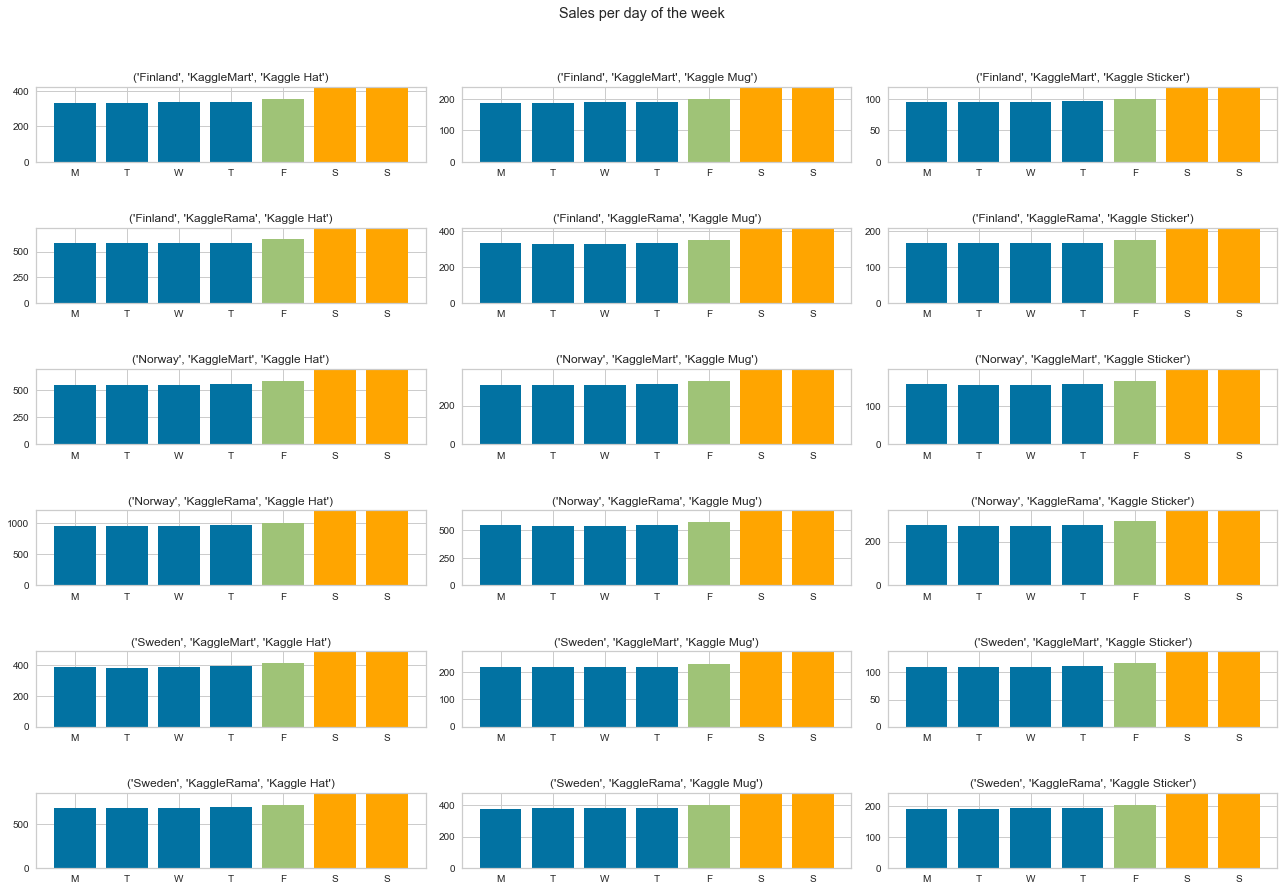

In [13]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    resampled = df.groupby(df.index.dayofweek).mean()
    ax.bar(range(7), resampled.num_sold, 
           color=['b']*4 + ['g'] + ['orange']*2)
    ax.set_title(combi)
    ax.set_xticks(ticks=range(7), labels=['M', 'T', 'W', 'T', 'F', 'S', 'S'])
    ax.set_ylim(0, resampled.num_sold.max())
plt.suptitle('Sales per day of the week', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

In [ ]:
import pandas_profiling
train.profile_report()

In [ ]:
#pd.get_dummies(train).corrwith(train["num_sold"])
train[['country', 'num_sold']].groupby(['country']).mean()

In [ ]:
train[['store', 'num_sold']].groupby(['store']).mean()

In [ ]:
train[['product', 'num_sold']].groupby(['product']).mean()

In [ ]:
exp1 = setup(train, target = 'num_sold',
             categorical_features=["country", "store","product"])

In [ ]:
# モデルの比較
compare_models()

In [ ]:
# Light Gradient Boosting Machineのモデルを作成
#rf = create_model('lightgbm')
rf = create_model('rf')

In [ ]:
# 解析結果の確認
evaluate_model(rf)
#plot_model(rf, plot = 'auc')

In [ ]:
#モデルの確定
tuned_rf = tune_model(rf)
#final_rf = finalize_model(rf)
#print(final_rf)

In [ ]:
final_rf = finalize_model(tuned_rf)

In [ ]:
#予測の実行
unseen_predictions = predict_model(final_rf, data = test)
print(test)

In [ ]:
unseen_predictions
unseen_predictions = unseen_predictions.rename(columns={'Label': 'num_sold'})

In [ ]:
#print(unseen_predictions.filter(items=['row_id', 'num_sold']))
unseen_predictions

In [ ]:
submit = unseen_predictions.filter(items=['row_id', 'num_sold'])

In [ ]:
submit.to_csv('submit0128.csv')